In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdCoordGen
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from schrodinger.livedesign import bbchem_endpoints
from schrodinger.livedesign import preprocessor
from schrodinger.livedesign import convert
from schrodinger.livedesign import setup_reaction
from schrodinger.livedesign import draw as ld_draw
from schrodinger.livedesign.preprocessor import ATOM_PROP_DUMMY_LABEL
from schrodinger.livedesign.molhash import ATOM_PROP_MAP_NUMBER
from schrodinger.livedesign.preprocessor import MOL_PROP_R_LABEL

from rdkit.Chem import rdRGroupDecomposition

from IPython.display import HTML
from rdkit.Chem import QED

import pandas as pd
import random
import itertools

from IPython.display import SVG
from IPython.display import SVG
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.minFontSize = 16
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.molSize = (900, 300)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/walker/builds/23-1/build/internal/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import rdkit_endpoints
def get_enumerate_info():
    print("Input core smiles above")
    scaff_smi = input()
    scaff = rdkit_endpoints.smiles_to_mol(scaff_smi, title = "Core")
    
    rgroups = dict()
    for rg_num in rdkit_endpoints._get_rgroup_labels(scaff):
        print(f"\nInput possible {rg_num}, separated by commas")
        ans = [rdkit_endpoints.smiles_to_mol(smi,title=rg_num) for smi in input().split(",")]
        rgroups[rg_num] = ans
    
    all_mols = [scaff]
    legends = ["Core"]
    for k, v in rgroups.items():
        for m in v:
            all_mols.append(m)
            legends.append(f"Possible {k}")
    return Draw.MolsToGridImage(all_mols,legends=legends,molsPerRow=3), rgroups, scaff

## Part 1: Input core and rgroup smiles

```
Some testing data

scaff: [*]C1CC([*])CC([*])O1 |$R1;;;;R2;;;R3;$|
R1s: *N1CCCC1, *O
R2s: *C, *C1CCCNC1
R3s: CC(-*)=O, *-C1CCNC1
```

Input core smiles above
[*]C1CC([*])CC([*])O1 |$R1;;;;R2;;;R3;$|

Input possible R1, separated by commas
*N1CCCC1, *O

Input possible R2, separated by commas
*C, *C1CCCNC1

Input possible R3, separated by commas
CC(-*)=O, *-C1CCNC1


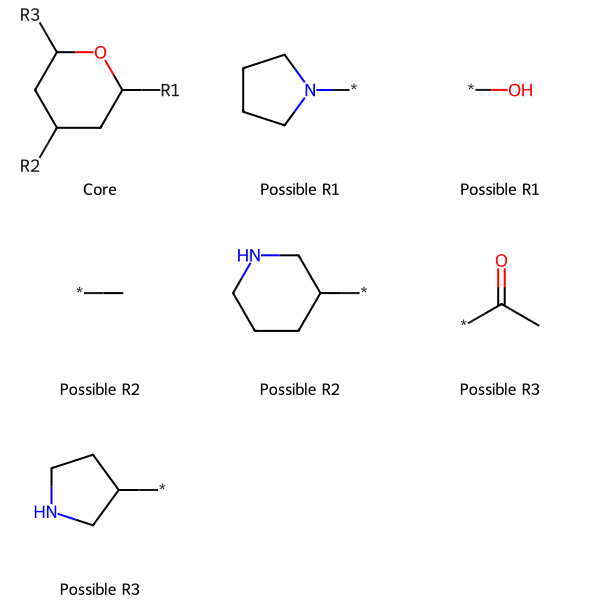

In [3]:
img, rgroups, scaff = get_enumerate_info()
img

## Part 2: Perform rgroup enumeration

Possible products:


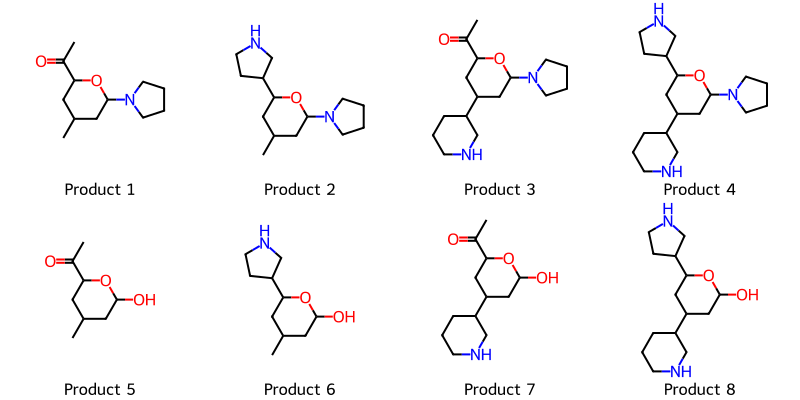

In [6]:
print("Possible products:")
products = rdkit_endpoints.rgroup_enumerate(scaff, rgroups)
scaff_copy = rdkit_endpoints._remove_rgroup_atoms(scaff)
rdDepictor.Compute2DCoords(scaff_copy)
for prod in products:
    rdDepictor.Compute2DCoords(prod)
    rdDepictor.GenerateDepictionMatching2DStructure(prod, scaff_copy)
titles = [f"Product {i}" for i in range(1, len(products) + 1)]
Draw.MolsToGridImage(products,legends = titles, molsPerRow=4)

## Step 3: Perform calculations on products & diplay data

From "Quantifying the chemical beauty of drugs", which RDKit QED calculations are based off of

```
Eight widely-used molecular properties were selected on the basis of published precedence for their relevance in determining druglikeness 3, 5, 22, 23:
    * MW: molecular weight
    * ALOGP: octanol-water partition coefficient
    * HBD: number of hydrogen bond donors 
    * HBA: number of hydrogen bond acceptors
    * PSA: molecular polar surface area
    * ROTB: number of rotatable bonds
    * AROM: the number of aromatic rings
    * ALERTS: number of structural alerts
```

We will probably add some properties for the students to calculate using the RDKit API that relate to the "goodness" value of the molecules.

Starting example: since we are working with small molecules, we want to limit # heavy atoms, so goodness value could include <5 heavy atoms. No more than x number of rotatable bonds, hydrophobicity. 

In [7]:
data, column_names = rdkit_endpoints.get_QED_props(products)
    
def sdf_formatter(mol):
    drawer = rdMolDraw2D.MolDraw2DSVG(200,200)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def display_table(df):
    format_dict={'Image' : sdf_formatter}
    raw = df.to_html(formatters=format_dict, escape=False,index=True)
    rval = HTML(raw)
    return display(rval)


df = pd.DataFrame.from_dict(data, orient='index', columns=column_names)
display_table(df)